In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tqdm

from functools import partial
import pyDOE
from sklearn.gaussian_process.kernels import Matern
import os

sys.path.append('..')
from robustGP.SURmodel import AdaptiveStrategy
from robustGP.test_functions import branin_2d, rosenbrock_general
import robustGP.tools as tools
import robustGP.gptools
import robustGP.acquisition.acquisition as ac
import robustGP.enrichment.Enrichment as enrich
import robustGP.optimisers as opt
%matplotlib inline


# Setup
## Plot settings

In [41]:
plt.style.use("seaborn-v0_8")
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsmath} \usepackage{amssymb}",
    "font.family": "sans-serif",
    "font.serif": ["Computer Modern Roman"],
    'image.cmap': u'viridis',
    'figure.figsize': [8, 8],
    'savefig.dpi': 200
})

## Utilities

In [42]:
def initialize_branin(initial_design=None):
    """
    Create new instance of AdaptiveStrategy of the Branin 2d function
    with LHS as initial design
    """
    NDIM = 2
    if initial_design is None:
        initial_design = 5 * NDIM
    bounds = np.asarray([(0, 1)] * NDIM)
    initial_design = pyDOE.lhs(
        n=NDIM, samples=initial_design, criterion="maximin", iterations=50
    )
    branin = AdaptiveStrategy(bounds, branin_2d)
    branin.fit_gp(
        initial_design,
        branin.evaluate_function(initial_design),
        Matern(np.ones(NDIM)),
        n_restarts_optimizer=50,
    )
    branin.set_idxU([1], ndim=2)
    return branin

bounds = np.asarray([[0, 1], [0, 1]])
# For plots
npts = 2**5
x, y = np.linspace(0, 1, npts), np.linspace(0, 1, npts)
(XY, (xmg, ymg)) = tools.pairify((x, y))
xl, yl = np.linspace(0, 1, 500), np.linspace(0, 1, 500)
(XYl, (xmgl, ymgl)) = tools.pairify((xl, yl))

def plot_enrichment(adaptive, title=None):
    m, s = adaptive.predict(XY, return_std=True)
    plt.subplot(2, 2, 1)
    plt.contourf(x, y, adaptive.evaluate_function(XY).reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)

    plt.title(r"$J$")

    plt.subplot(2, 2, 2)
    plt.contourf(x, y, m.reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$m_Z$")

    plt.subplot(2, 2, 3)
    plt.contourf(x, y, s.reshape(npts, npts).T)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$\sigma^2_Z$")

    plt.subplot(2, 2, 4)
    plt.contourf(x, y, (m.reshape(npts, npts) - adaptive.function(XY).reshape(npts, npts))**2)
    plt.colorbar()
    plt.scatter(adaptive.gp.X_train_[:10, 0], adaptive.gp.X_train_[:10, 1], marker='x', c='white', alpha=0.5)
    plt.scatter(adaptive.gp.X_train_[10:, 0], adaptive.gp.X_train_[10:, 1], marker='x', c='red', alpha=0.5)
    plt.title(r"$|J - m_Z|^2$")

    plt.suptitle(title)
    plt.tight_layout()

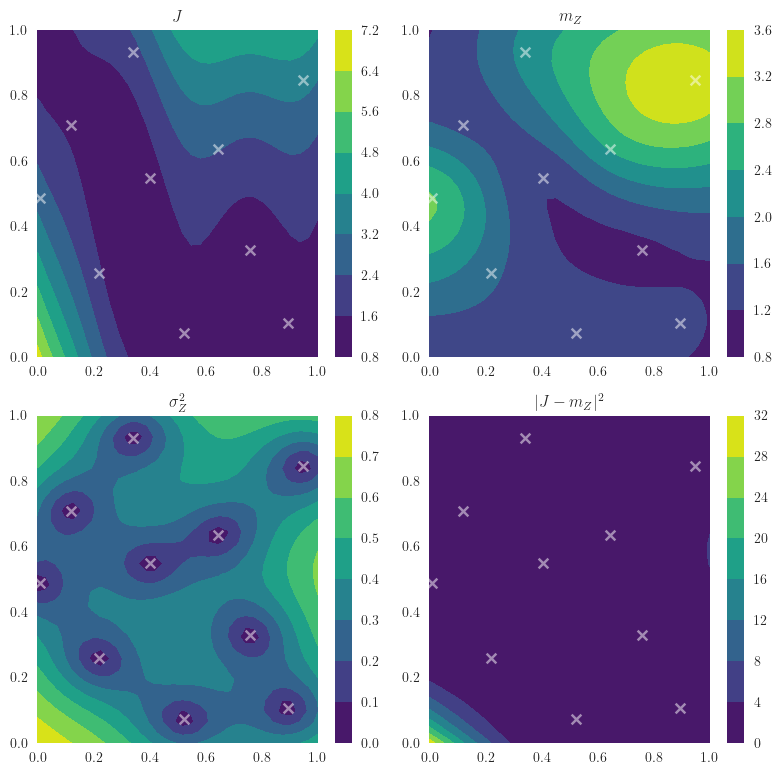

In [43]:
branin = initialize_branin()
plot_enrichment(branin)

## Monte-Carlo Enrichement

In [44]:
branin = initialize_branin()
montecarlo = enrich.MonteCarloEnrich(dim=2, bounds=bounds, sampler=None)
branin.set_enrichment(montecarlo)
branin.run(Niter=20)

100%|██████████| 20/20 [00:11<00:00,  1.81it/s]


[]

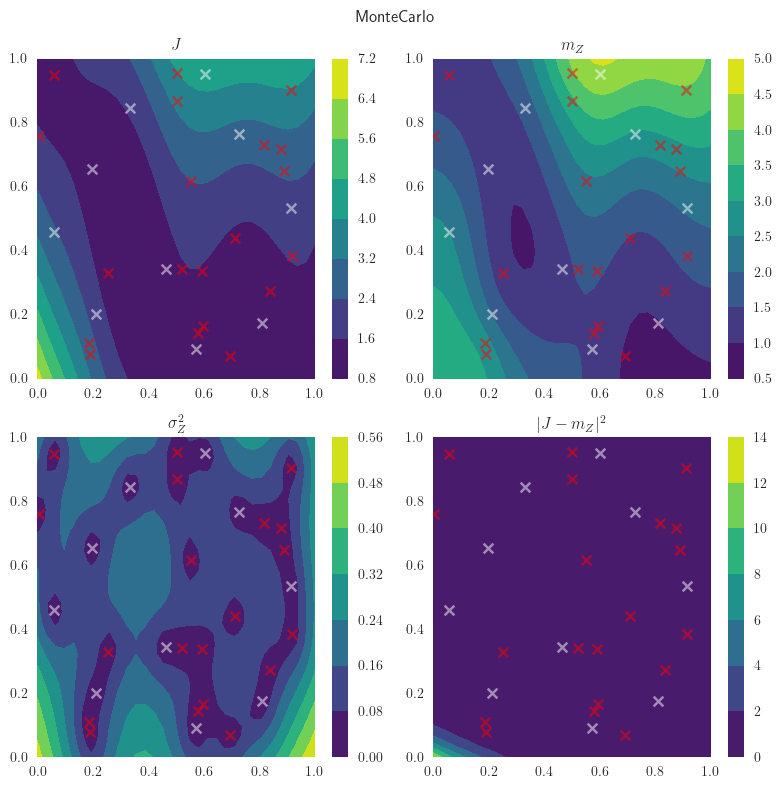

In [45]:
plot_enrichment(branin, 'MonteCarlo')

## EGO algorithm

In [46]:
branin = initialize_branin()
EGO = enrich.OneStepEnrichment(bounds)
EGO.set_criterion(ac.expected_improvement, maxi=True)  #
# EGO.set_optim(opt.optimize_with_restart, **{"nrestart": 20})
branin.set_enrichment(EGO)
branin.run(Niter=20)

100%|██████████| 20/20 [00:12<00:00,  1.56it/s]


[]

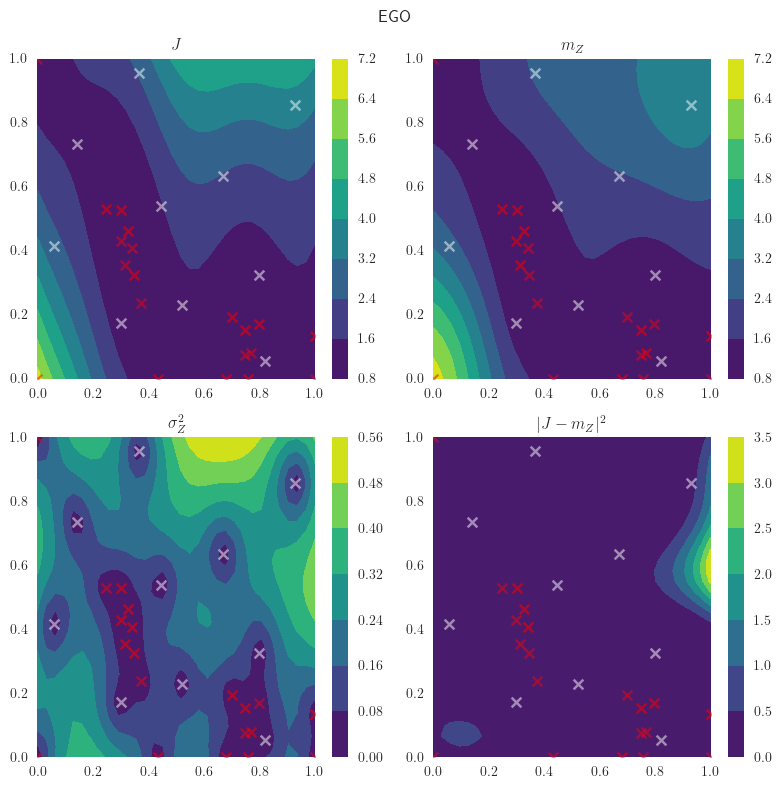

In [47]:
plot_enrichment(branin, 'EGO')

## PEI

In [48]:
branin = initialize_branin()
PEI = enrich.OneStepEnrichment(bounds)
PEI.set_criterion(ac.PEI, maxi=True)  #
branin.set_enrichment(PEI)
branin.run(Niter=20)

100%|██████████| 20/20 [10:49<00:00, 32.45s/it]


[]

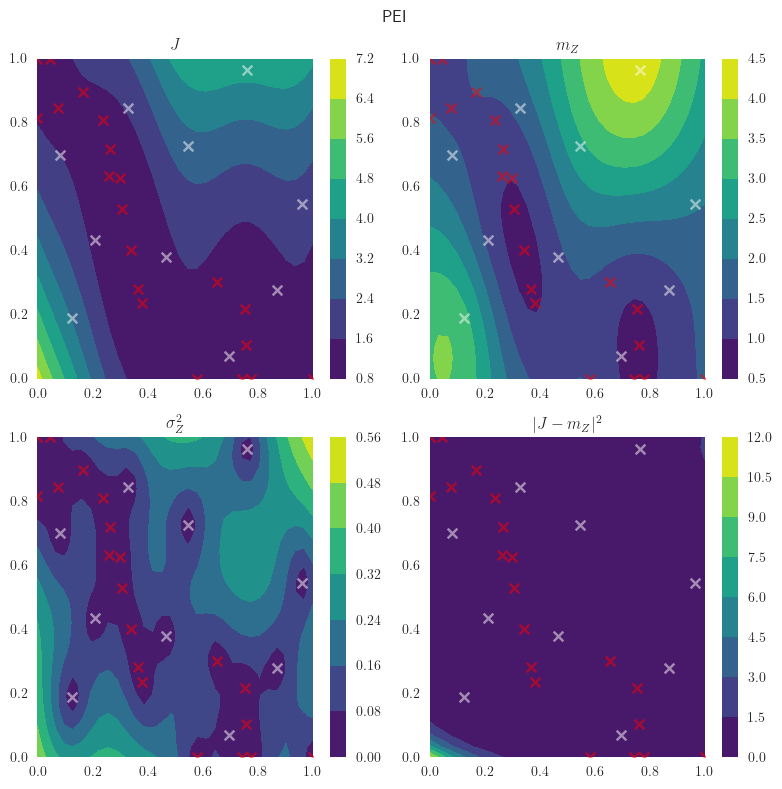

In [49]:
plot_enrichment(branin, 'PEI')

## Maximum of variance

In [50]:
branin = initialize_branin()
maxvar = enrich.OneStepEnrichment(bounds)
maxvar.set_criterion(ac.prediction_variance, maxi=True)  #
branin.set_enrichment(maxvar)
branin.run(Niter=20)

100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


[]

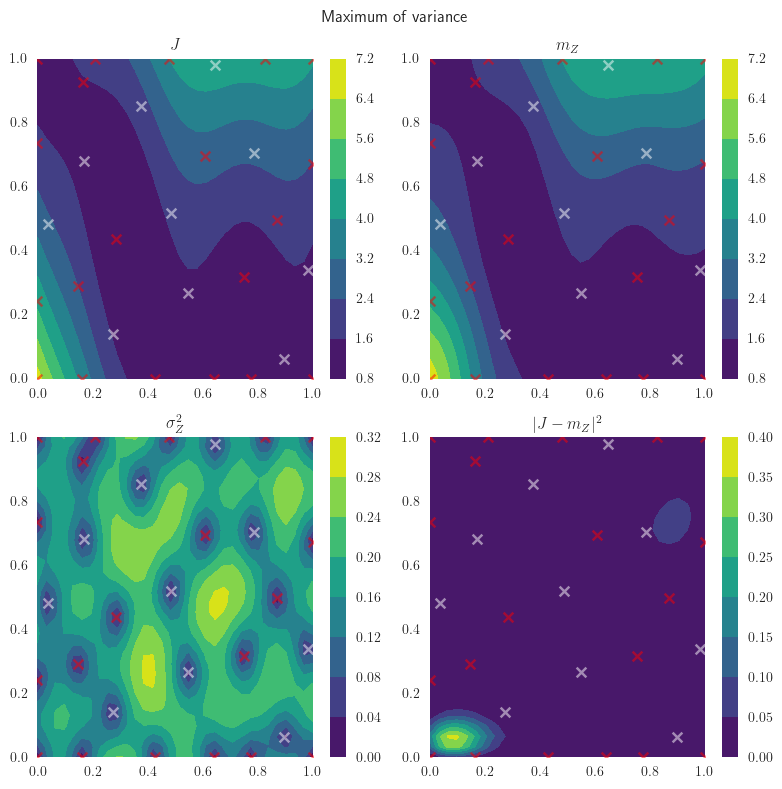

In [51]:
plot_enrichment(branin, 'Maximum of variance')

## Custom criterion

In [57]:
branin = initialize_branin()
lowerbound = enrich.OneStepEnrichment(bounds)
def quantile(arg, X):
    m, s = arg.predict(X, return_std=True)
    return m - 2 * s
lowerbound.set_criterion(quantile)  #
branin.set_enrichment(lowerbound)
branin.run(Niter=20)

100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


[]

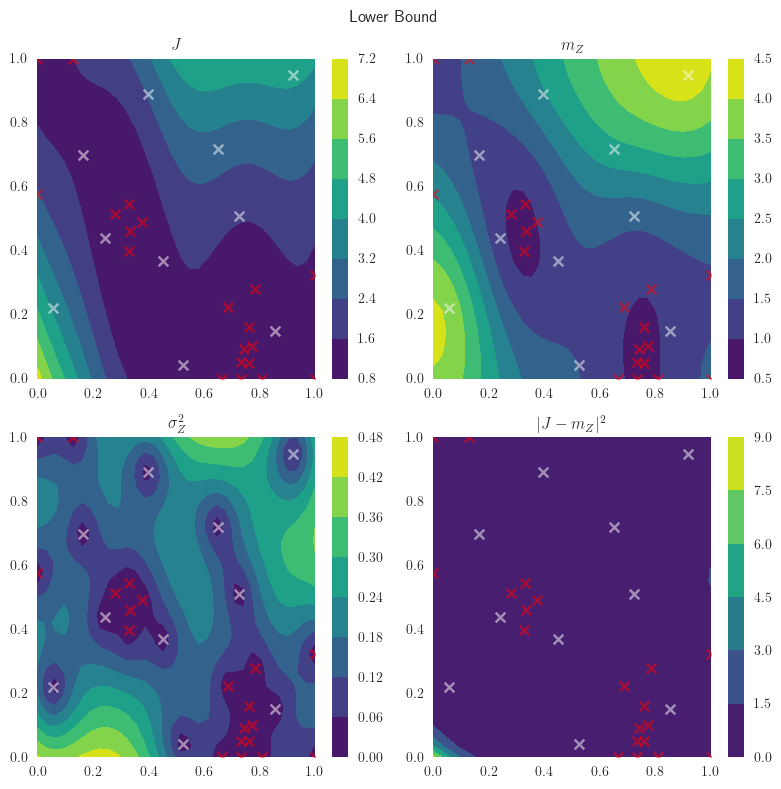

In [58]:
plot_enrichment(branin, 'Lower Bound')